# Bayesian Digressions: Bayesian Model Selection

From [Frequentism and Bayesianism V: Model Selection](http://jakevdp.github.io/blog/2015/08/07/frequentism-and-bayesianism-5-model-selection/)

## Model Fitting vs Model Selection

The difference between model fitting and model selection is often a cause of confusion. Model fitting proceeds by assuming a particular model is true, and tuning the model so it provides the best possible fit to the data. Model selection, on the other hand, asks the larger question of whether the assumptions of the model are compatible with the data.

Let's make this more concrete. By model here I essentially mean a formula, usually with tunable parameters, which quantifies the likelihood of observing your data. For example, your model might consist of the statement, "the $(x, y)$ observations come from a straight line, with known normal measurement errors $\sigma_y$". Labeling this model $M_1$, we can write:

$$
y_{M_1}(x; \theta) = \theta_0 + \theta_1 x \\
y∼\mathcal{N}(y_{M_1}, \sigma^2_y)
$$

where the second line indicates that the observed $y$ is normally distributed about the model value, with variance $\sigma_y^2$. There are two tunable parameters to this model, represented by the vector $\theta = [\theta_0, \theta_1]$ (i.e. the slope and intercept).

Another model might consist of the statement "the observations $(x, y)$ come from a quadratic curve, with known normal measurement errors $\sigma_y$". Labeling this model $M_2$, we can write:

$$
y_{M_2}(x; \theta) = \theta_0 + \theta_1 x + \theta_2 x^2 \\
y∼\mathcal{N}(y_{M_2}, \sigma^2_y)
$$

There are three tunable parameters here, again represented by the vector $\theta$.

Model fitting, in this case, is the process of finding constraints on the values of the parameters $\theta$ within each model. That is, it allows you to make statements such as, "assuming $M_1$ is true, this particular $\theta$ gives the best-fit line" or "assuming $M_2$ is true, this particular vector $\theta$ gives the best-fit curve." Model fitting proceeds without respect to whether the model is capable of describing the data well; it just arrives at the best-fit model under the assumption that the model is accurate.

Model selection, on the other hand, is not concerned with the parameters themselves, but with the question of whether the model is capable of describing the data well. That is, it allows you to say, "for my data, a line ($M_1$) provides a better fit than a quadratic curve ($M_2$)".

Let's make this more concrete by introducing some data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 15})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
from time import time
# import random
# random.seed(123)
import emcee
import corner

In [2]:
data = np.array([[ 0.42,  0.72,  0.  ,  0.3 ,  0.15,
                   0.09,  0.19,  0.35,  0.4 ,  0.54,
                   0.42,  0.69,  0.2 ,  0.88,  0.03,
                   0.67,  0.42,  0.56,  0.14,  0.2  ],
                 [ 0.33,  0.41, -0.22,  0.01, -0.05,
                  -0.05, -0.12,  0.26,  0.29,  0.39, 
                   0.31,  0.42, -0.01,  0.58, -0.2 ,
                   0.52,  0.15,  0.32, -0.13, -0.09 ],
                 [ 0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1  ]])
x, y, sigma_y = data

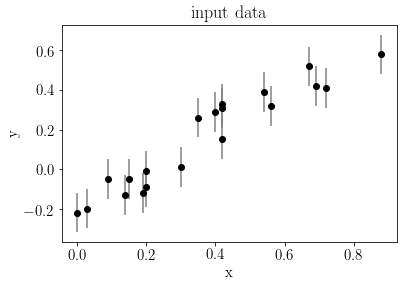

In [3]:
x, y, sigma_y = data
fig, ax = plt.subplots()
ax.errorbar(x, y, sigma_y, fmt='ok', ecolor='gray')
ax.set(xlabel='x', ylabel='y', title='input data');

Our central model selection question will be this: **what better fits this data: a linear ($M_1$) or quadratic ($M_2$) curve?**

Let's create a function to compute these models given some data and parameters; for convenience, we'll make a very general polynomial model function:

In [4]:
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    return sum(t * x ** n for (n, t) in enumerate(theta))

If the theta variable is of length 2, this corresponds to the linear model ($M_1$). If the theta variable is length 3, this corresponds to the quadratic model ($M_2$).

As detailed in my previous posts, both the frequentist and Bayesian approaches to model fitting often revolve around the likelihood, which, for independent errors, is the product of the probabilities for each individual point. Here is a function which computes the log-likelihood for the two models:

In [5]:
from scipy import stats

def logL(theta, model=polynomial_fit, data=data):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(stats.norm.logpdf(*args)
               for args in zip(y, y_fit, sigma_y))

Both the Bayesian and frequentist approaches are based on the likelihood, and the standard frequentist approach is to find the model which maximizes this expression. Though there are efficient closed-form ways of maximizing this, we'll use a direct optimization approach here for clarity:

In [6]:
from scipy import optimize

def best_theta(degree, model=polynomial_fit, data=data):
    theta_0 = (degree + 1) * [0]
    neg_logL = lambda theta: -logL(theta, model, data)
    return optimize.fmin_bfgs(neg_logL, theta_0, disp=False)

theta1 = best_theta(1)
theta2 = best_theta(2)

Let's now we can visually compare the maximum-likelihood degree-1 and degree-2 models:

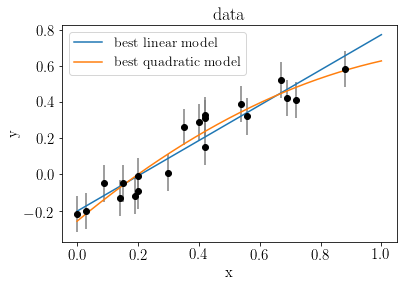

In [7]:
xfit = np.linspace(0, 1, 1000)
fig, ax = plt.subplots()
ax.errorbar(x, y, sigma_y, fmt='ok', ecolor='gray')
ax.plot(xfit, polynomial_fit(theta1, xfit), label='best linear model')
ax.plot(xfit, polynomial_fit(theta2, xfit), label='best quadratic model')
ax.legend(loc='best', fontsize=14)
ax.set(xlabel='x', ylabel='y', title='data');

The crux of the model selection question is this: how we can quantify the difference between these models and decide which model better describes our data?

### Model Selection

Similarly, when comparing two models $M_1$ and $M_2$, the frequentist and Bayesian approaches look at different quantities:

- frequentists compare the *model likelihood*, $P(D~|~M_1)$ and $P(D~|~M_2)$
- Bayesians compare the *model posterior*, $P(M_1~|~D)$ and $P(M_2~|~D)$

Notice here that the parameter values $\theta$ no longer appear: we're not out to compare how well *particular fits* of the two models describe data; we're out to compare how well *the models themselves* describe the data.
Unlike the parameter likelihood $P(D~|~\theta, M)$ above, neither quantity here is directly related to the likelihood expression, and so we must figure out how to re-express the desired quantity in terms we can compute.

For model selection, in many ways Bayesians have the advantage, at least in theory.
Through a combination of Bayes Theorem and probability axioms, we can re-express the model posterior $P(M~|~D)$ in terms of computable quantities and priors:

First, using Bayes' Theorem:

$$
P(M~|~D) = P(D~|~M)\frac{P(M)}{P(D)}
$$

Using the definition of conditional probability, the first term can be expressed as an integral over the parameter space of the likelihood:

$$
P(D~|~M) = \int_\Omega P(D~|~\theta, M) P(\theta~|~M) d\theta
$$

Notice that this integral is over the exact quantity optimized in the case of Bayesian model *fitting*.

The remaining terms are priors, the most problematic of which is $P(D)$ – the prior probability of seeing your data *without reference to any model*.
I'm not sure that $P(D)$ could ever be actually computed in the real world, but fortunately it can be canceled by computing the *odds ratio* between two alternative models:

$$
O_{21} \equiv \frac{P(M_2~|~D)}{P(M_1~|~D)} = \frac{P(D~|~M_2)}{P(D~|~M_1)}\frac{P(M_2)}{P(M_1)}
$$

We now have a means of comparing two models via computable quantities: an integral over the likelihood, and a prior odds for each model.
Often the ratio of prior odds is assumed to be near unity, leaving only the well-defined (but often computationally intensive) integral over likelihood for each model.
More on this below.

Here the ratio $P(M_2) / P(M_1)$ is the *prior odds ratio*, and is often assumed to be equal to 1 if no compelling prior evidence favors one model over another.
The ratio $P(D~|~M_2) / P(D~|~M_1)$ is the *Bayes factor*, and is the key to Bayesian model selection.

The Bayes factor can be computed by evaluating the integral over the parameter likelihood:

$$
P(D~|~M) = \int_\Omega P(D~|~\theta, M) P(\theta~|~M) d\theta
$$

This integral is over the entire parameter space of the model, and thus can be extremely computationally intensive, especially as the dimension of the model grows beyond a few.
For the 2-dimensional and 3-dimensional models we are considering here, however, this integral can be computed directly via numerical integration.

We'll start, though, by using an MCMC to draw samples from the posterior in order to solve the *model fitting* problem.
We will use the [emcee](http://dan.iel.fm/emcee) package, which requires us to first define functions which compute the prior, likelihood, and posterior under each model:

In [8]:
def log_prior(theta):
    # size of theta determines the model.
    # flat prior over a large range
    if np.any(abs(theta) > 100):
        return -np.inf  # log(0)
    else:
        return 200 ** -len(theta)

def log_likelihood(theta, data=data):
    x, y, sigma_y = data
    yM = polynomial_fit(theta, x)
    return -0.5 * np.sum(np.log(2 * np.pi * sigma_y ** 2)
                         + (y - yM) ** 2 / sigma_y ** 2)

def log_posterior(theta, data=data):
    theta = np.asarray(theta)
    return log_prior(theta) + log_likelihood(theta, data)

Next we draw samples from the posterior using MCMC:

In [9]:
def compute_mcmc(degree, data=data,
                   log_posterior=log_posterior,
                   nwalkers=50, nburn=1000, nsteps=2000):
    ndim = degree + 1  # this determines the model
    rng = np.random.RandomState(0)
    starting_guesses = rng.randn(nwalkers, ndim)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data])
    sampler.run_mcmc(starting_guesses, nsteps)
    trace = sampler.chain[:, nburn:, :].reshape(-1, ndim)
    return trace

trace_2D = compute_mcmc(1)
trace_3D = compute_mcmc(2)

The output is a trace, or a series of samples which by design should reflect the posterior distribution.
To visualize the posterior samples, I like to use seaborn's ``jointplot`` (for 2D samples) or ``PairGrid`` (for N-D samples):

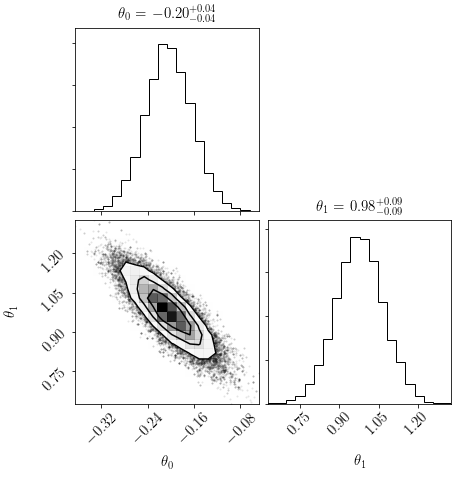

In [11]:
fig = corner.corner(trace_2D, labels=[r'$\theta_0$', r'$\theta_1$'],
#                     quantiles=[0.16, 0.5, 0.84],
#                     truths=[mu_true, sigma_true],
                    show_titles=True, 
                    title_kwargs={"fontsize": 15})
fig.set_size_inches(7, 7)

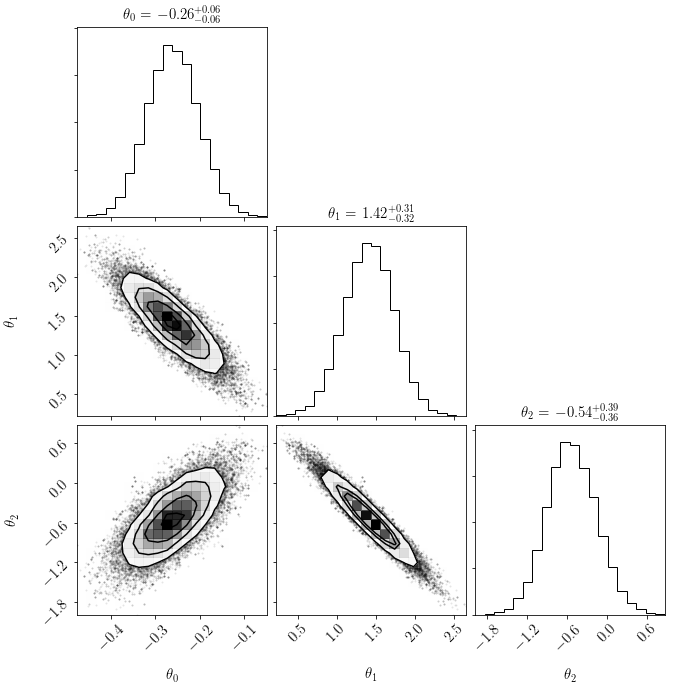

In [13]:
fig = corner.corner(trace_3D, labels=[r'$\theta_0$', r'$\theta_1$', r'$\theta_2$'],
#                     quantiles=[0.16, 0.5, 0.84],
#                     truths=[mu_true, sigma_true],
                    show_titles=True, 
                    title_kwargs={"fontsize": 15})
fig.set_size_inches(10, 10)

These samples give us a good idea of what the posterior for each model looks like, but we still must integrate this posterior to find the Bayes factor.

For these lower-dimensional models, we'll do direct numerical integration using tools from the ``scipy.integrate`` package to integrate the posterior and compute the odds ratio. 
The call signature of the multiple integration routines is a bit confusing – I suggest referring to the [scipy.integrate documentation](http://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html) to read about the inputs.

In [14]:
from scipy import integrate

def integrate_posterior_2D(log_posterior, xlim, ylim, data=data):
    func = lambda theta1, theta0: np.exp(log_posterior([theta0, theta1], data))
    return integrate.dblquad(func, xlim[0], xlim[1],
                             lambda x: ylim[0], lambda x: ylim[1])

def integrate_posterior_3D(log_posterior, xlim, ylim, zlim, data=data):
    func = lambda theta2, theta1, theta0: np.exp(log_posterior([theta0, theta1, theta2], data))
    return integrate.tplquad(func, xlim[0], xlim[1],
                             lambda x: ylim[0], lambda x: ylim[1],
                             lambda x, y: zlim[0], lambda x, y: zlim[1])

The tricky part of the integration is choosing the integration limits correctly; fortunately we can use the MCMC traces to find appropriate values.
We'll use IPython's ``%time`` magic to record how long each takes:

In [15]:
xlim, ylim = zip(trace_2D.min(0), trace_2D.max(0))
%time Z1, err_Z1 = integrate_posterior_2D(log_posterior, xlim, ylim)
print("Z1 =", Z1, "+/-", err_Z1)

Wall time: 388 ms
Z1 = 46941752.233524635 +/- 2.2926240634555493


In [16]:
xlim, ylim, zlim = zip(trace_3D.min(0), trace_3D.max(0))
%time Z2, err_Z2 = integrate_posterior_3D(log_posterior, xlim, ylim, zlim)
print("Z2 =", Z2, "+/-", err_Z2)

Wall time: 1min 29s
Z2 = 111093730.11107068 +/- 16.92905305143918


The Bayes factor is simply the quotient of the two integrals:

In [17]:
print("Bayes factor: {:.2f}".format(Z2 / Z1))

Bayes factor: 2.37


The Bayes factor favors the quadratic model, but only slightly (an odds of about 7 to 3).
In fact, this value for the Bayes factor ranks as "not worth a mere mention" according to the scale proposed by [Kass & Raferty (1995)](https://www.andrew.cmu.edu/user/kk3n/simplicity/KassRaftery1995.pdf) an influential paper on the subject.

Notice that this interpretation is very similar to what we found with the frequentist approach above, which favors the quadratic model but has too large a $p$-value to support discarding the simpler linear model. Indeed, at the risk of causing die-hard Bayesians to cringe, you can argue roughly that the equivalent "Bayesian $p$-value" assosiated with this odds ratio is

In [2]:
from scipy import stats
np.random.seed(1)  # for repeatability

F_true = 1000  # true flux, say number of photons measured in 1 second
N = 50 # number of measurements
F = stats.poisson(F_true).rvs(N)  # N measurements of the flux
e = np.sqrt(F)  # errors on Poisson counts estimated via square root

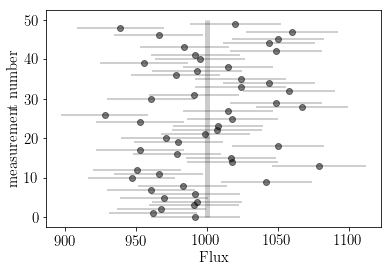

In [3]:
fig, ax = plt.subplots()
ax.errorbar(F, np.arange(N), xerr=e, fmt='ok', ecolor='gray', alpha=0.5)
ax.vlines([F_true], 0, N, linewidth=5, alpha=0.2)
ax.set_xlabel("Flux");ax.set_ylabel("measurement number");

## Bayesian Approach to Simple Photon Counts
The Bayesian approach, as you might expect, begins and ends with probabilities. It recognizes that what we fundamentally want to compute is our knowledge of the parameters in question, i.e. in this case,

$$
P(F_{\text{true}} \,|\, D)
$$

Note that this formulation of the problem is fundamentally contrary to the frequentist philosophy, which says that probabilities have no meaning for model parameters like $F_{\text{true}}$. Nevertheless, within the Bayesian philosophy this is perfectly acceptable.

To compute this result, Bayesians next apply Bayes' Theorem, a fundamental law of probability:

$$
P(F_{\text{true}} \,|\, D) = \frac{P(D \,|\, F_{\text{true}}) \, P(F_{\text{true}})}{P(D)}
$$

Though Bayes' theorem is where Bayesians get their name, it is not this law itself that is controversial, but the Bayesian interpretation of probability implied by the term $P(F_{\text{true}} \,|\, D)$.

Let's take a look at each of the terms in this expression:

 - $P(F_{\text{true}} \,|\, D)$: The **posterior**, or the probability of the model parameters given the data: this is the result we want to compute.
 - $P(D \,|\, F_{\text{true}})$: The **likelihood**, which is proportional to the $\mathcal{L}(D \,|\, F_{\text{true}})$ in the frequentist approach.
 - $P(F_{\text{true}})$: The **model prior**, which encodes what we knew about the model prior to the application of the data $D$.
 - $P(D)$: The **data probability**, which in practice amounts to simply a normalization term.
 
If we set the prior $P(F_{\text{true}}) \propto 1$ (a flat prior), we find

$$
P(F_{\text{true}} \,|\, D) \propto \mathcal{L}(D \,|\, F_{\text{true}})
$$

and the Bayesian probability is maximized at precisely the same value as the frequentist result! So despite the philosophical differences, we see that (for this simple problem at least) the Bayesian and frequentist point estimates are equivalent.

Let's address how Bayesian results are generally computed in practice. For a one parameter problem like the one considered here, it's as simple as computing the posterior probability $P(F_{\rm true}~|~D)$ as a function of $F_{\rm true}$: this is the distribution reflecting our knowledge of the parameter $F_{\rm true}$. But as the dimension of the model grows, this direct approach becomes increasingly intractable. For this reason, Bayesian calculations often depend on sampling methods such as [Markov Chain Monte Carlo (MCMC)](http://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo).

For a practical example of applying an MCMC approach let's use Dan Foreman-Mackey's excellent [emcee](http://dan.iel.fm/emcee/current/)  package.  Keep in mind here that the goal is to *generate a set of points drawn from the posterior probability distribution*, and to use those points to determine the answer we seek.

Given a single observation $D_i = (F_i, e_i)$, we can compute the probability distribution of the measurement given the true flux $F_{\rm true}$ given our assumption of Gaussian errors:

$$ P(D_i~|~F_{\rm true}) = \frac{1}{\sqrt{2\pi e_i^2}} \exp{\left[\frac{-(F_i - F_{\rm true})^2}{2 e_i^2}\right]} $$

This should be read "the probability of $D_i$ given $F_{\rm true}$ equals ...". You should recognize this as a normal distribution with mean $F_{\rm true}$ and standard deviation $e_i$.

We construct the **likelihood function** by computing the product of the probabilities for each data point:

$$\mathcal{L}(D~|~F_{\rm true}) = \prod_{i=1}^N P(D_i~|~F_{\rm true})$$

Here $D = \{D_i\}$ represents the entire set of measurements. Because the value of the likelihood can become very small, it is often more convenient to instead compute the log-likelihood.  Combining the previous two equations and computing the log, we have

$$\log\mathcal{L} = -\frac{1}{2} \sum_{i=1}^N \left[ \log(2\pi  e_i^2) + \frac{(F_i - F_{\rm true})^2}{e_i^2} \right]$$


To perform this MCMC, we start by defining Python functions for the prior $P(F_{\rm true})$, the likelihood $P(D~|~F_{\rm true})$, and the posterior $P(F_{\rm true}~|~D)$, noting that none of these need be properly normalized. Our model here is one-dimensional, but to handle multi-dimensional models we'll define the model in terms of an array of parameters $\theta$, which in this case is $\theta = [F_{\rm true}]$:

In [4]:
def log_prior(theta):
    return 1  # flat prior

def log_likelihood(theta, F, e):
    return -0.5 * np.sum(np.log(2 * np.pi * e ** 2)
                         + (F - theta[0]) ** 2 / e ** 2)

def log_posterior(theta, F, e):
    return log_prior(theta) + log_likelihood(theta, F, e)

Now we set up the problem, including generating some random starting guesses for the multiple chains of points.

In [5]:
ndim = 1  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take

# we'll start at random locations between 0 and 2000
starting_guesses = 2000 * np.random.rand(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[F, e])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].ravel()  # discard burn-in points

In [6]:
sample.shape

(50000,)

If this all worked correctly, the array `sample` should contain a series of 50000 points drawn from the posterior. Let's plot them and check:

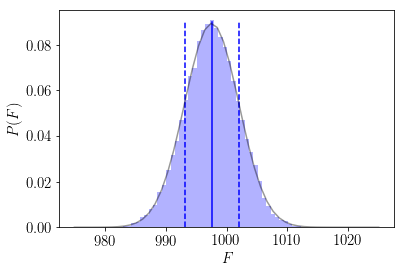

In [7]:
# plot a histogram of the sample
plt.hist(sample, bins=50, histtype="stepfilled", alpha=0.3, normed=True, color='b')

# plot a best-fit Gaussian
F_fit = np.linspace(975, 1025)
pdf = stats.norm(np.mean(sample), np.std(sample)).pdf(F_fit)

p16 = np.percentile(sample, 16)
p50 = np.percentile(sample, 50)
p84 = np.percentile(sample, 84)
y_max = 0.09
plt.plot([p16, p16], [0, y_max], 'b--')
plt.plot([p84, p84], [0, y_max], 'b--')
plt.plot([p50, p50], [0, y_max], 'b-')

plt.plot(F_fit, pdf, '-k', alpha=0.4)
plt.xlabel("$F$"); plt.ylabel("$P(F)$");

We end up with a sample of points drawn from the (normal) posterior distribution. The mean and standard deviation of this posterior are the corollary of the frequentist maximum likelihood estimate above:

In [8]:
print("""
      F_true = {0}
      F_est  = {1:.0f} +/- {2:.0f} (based on {3} measurements)
      """.format(F_true, np.mean(sample), np.std(sample), N))


      F_true = 1000
      F_est  = 998 +/- 4 (based on 50 measurements)
      


In [9]:
print(f'percentile 16: {p16:.2f}')
print(f'percentile 50: {p50:.2f}')
print(f'percentile 84: {p84:.2f}')
print(f'μ = {p50:.0f}')
print(f'σ = {p50-p16:.0f}')

percentile 16: 993.15
percentile 50: 997.56
percentile 84: 1002.01
μ = 998
σ = 4


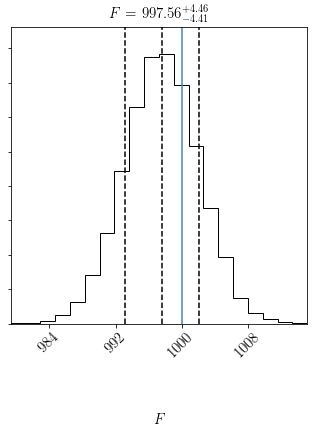

In [12]:
fig = corner.corner(sample, labels=[r'$F$'],
                    quantiles=[0.16, 0.5, 0.84],
                    truths=[F_true],
                    show_titles=True, 
                    title_kwargs={"fontsize": 15})
fig.set_size_inches(7, 7)

## Adding a Dimension: Exploring a more sophisticated model

Let's briefly take a look at a more complicated situation, and compare the frequentist and Bayesian results yet again.  Above we assumed that the star was static: now let's assume that we're looking at an object which we suspect has some stochastic variation &mdash; that is, it varies with time, but in an unpredictable way (a Quasar is a good example of such an object).

We'll propose a simple 2-parameter Gaussian model for this object: $\theta = [\mu, \sigma]$ where $\mu$ is the mean value, and $\sigma$ is the standard deviation of the variability *intrinsic to the object*.  Thus our model for the probability of the true flux at the time of each observation looks like this:

$$ F_{\rm true} \sim \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[-\frac{(F - \mu)^2}{2\sigma^2}\right]$$

Now, we'll again consider $N$ observations each with their own error. We can generate them this way:

In [13]:
np.random.seed(42)  # for reproducibility
N = 100  # we'll use more samples for the more complicated model
mu_true, sigma_true = 1000, 15  # stochastic flux model

F_true = stats.norm(mu_true, sigma_true).rvs(N)  # (unknown) true flux
F = stats.poisson(F_true).rvs()  # observed flux: true flux plus Poisson errors.
e = np.sqrt(F)  # root-N error, as above

The resulting likelihood is the convolution of the intrinsic distribution with the error distribution, so we have

$$\mathcal{L}(D~|~\theta) = \prod_{i=1}^N \frac{1}{\sqrt{2\pi(\sigma^2 + e_i^2)}}\exp\left[\frac{-(F_i - \mu)^2}{2(\sigma^2 + e_i^2)}\right]$$

In [14]:
def log_likelihood(theta, F, e):
    return -0.5 * np.sum(np.log(2 * np.pi * (theta[1] ** 2 + e ** 2))
                         + (F - theta[0]) ** 2 / (theta[1] ** 2 + e ** 2))

### Varying Photon Counts: The Bayesian Approach

The Bayesian approach to this problem is almost exactly the same as it was in the previous problem, and we can set it up by slightly modifying the above code.

In [15]:
def log_prior(theta):
    # sigma needs to be positive.
    if theta[1] <= 0:
        return -np.inf
    else:
        return 0

def log_posterior(theta, F, e):
    return log_prior(theta) + log_likelihood(theta, F, e)

# same setup as above:
ndim, nwalkers = 2, 50
nsteps, nburn = 2000, 1000

starting_guesses = np.random.rand(nwalkers, ndim)
starting_guesses[:, 0] *= 2000  # start mu between 0 and 2000
starting_guesses[:, 1] *= 20    # start sigma between 0 and 20

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[F, e])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, 2)

In [16]:
# from astroML.plotting import plot_mcmc
# fig = plt.figure()
# ax = plot_mcmc(sample.T, fig=fig, labels=[r'$\mu$', r'$\sigma$'], colors='k')
# ax[0].plot(sample[:, 0], sample[:, 1], ',k', alpha=0.1)
# ax[0].plot([mu_true], [sigma_true], 'o', color='red', ms=10);

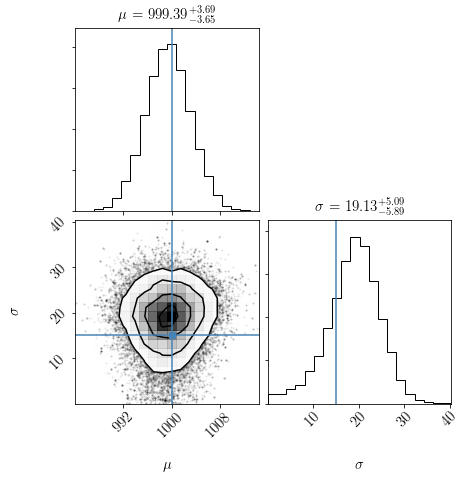

In [17]:
fig = corner.corner(sample, labels=[r'$\mu$', r'$\sigma$'],
#                     quantiles=[0.16, 0.5, 0.84],
                    truths=[mu_true, sigma_true],
                    show_titles=True, 
                    title_kwargs={"fontsize": 15})
fig.set_size_inches(7, 7)

In [18]:
sample.shape

(50000, 2)

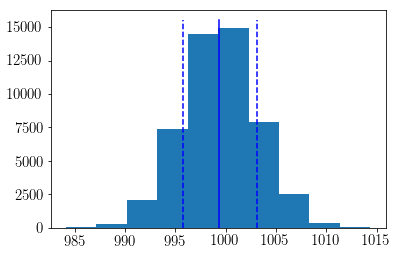

In [30]:
plt.hist(sample[:,0])

p16 = np.percentile(sample[:,0], 16)
p50 = np.percentile(sample[:,0], 50)
p84 = np.percentile(sample[:,0], 84)
y_max = 15500
plt.plot([p16, p16], [0, y_max], 'b--')
plt.plot([p84, p84], [0, y_max], 'b--')
plt.plot([p50, p50], [0, y_max], 'b-');

In [29]:
print(f'percentile 16: {p16:.2f}')
print(f'percentile 50: {p50:.2f}')
print(f'percentile 84: {p84:.2f}')
print(f'μ = {p50:.0f}')
print(f'σ- = {p50-p16:.0f}')
print(f'σ+ = {p84-p50:.0f}')

percentile 16: 995.73
percentile 50: 999.39
percentile 84: 1003.08
μ = 999
σ- = 4
σ+ = 4


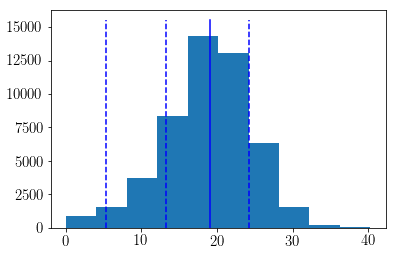

In [34]:
plt.hist(sample[:, 1])

p02 = np.percentile(sample[:,1], 2.5)
p16 = np.percentile(sample[:,1], 16)
p50 = np.percentile(sample[:,1], 50)
p84 = np.percentile(sample[:,1], 84)
y_max = 15500
plt.plot([p02, p02], [0, y_max], 'b--')
plt.plot([p16, p16], [0, y_max], 'b--')
plt.plot([p84, p84], [0, y_max], 'b--')
plt.plot([p50, p50], [0, y_max], 'b-');

In [36]:
print(f'percentile 16: {p16:.2f}')
print(f'percentile 50: {p50:.2f}')
print(f'percentile 84: {p84:.2f}')
print(f'μ = {p50:.0f}')
print(f'σ- = {p50-p16:.0f}')
print(f'σ+ = {p84-p50:.0f}')

percentile 16: 13.25
percentile 50: 19.13
percentile 84: 24.22
μ = 19
σ- = 6
σ+ = 5


In [33]:
50-95/2, 50+95/2

(2.5, 97.5)